<a href="https://colab.research.google.com/github/JINENDRI/DataStorm-2.0/blob/main/Random_Forest_GridSearchCV%20-%20Day3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Loading Required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

#### Loading and viewing the datasets

In [ ]:
# Loading train set
hotel_data_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Strome_2.0/Hotel-A-train.csv')

# Loading validation set
hotel_data_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_Strome_2.0/Hotel-A-validation.csv')

hotel_data_train

,Reservation-id,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate
0,39428300,F,40,Latino,Grad,<25K,North,City Hotel,7/1/2015,7/2/2015,5/21/2015,2,2,0,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218
1,77491756,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,7/1/2015,7/2/2015,5/26/2015,3,3,0,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185
2,73747291,F,42,caucasian,Grad,<25K,East,City Hotel,7/2/2015,7/6/2015,6/29/2015,3,3,0,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119
3,67301739,M,25,African American,College,>100K,South,Airport Hotels,7/2/2015,7/3/2015,6/20/2015,4,3,0,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144
4,77222321,F,62,Latino,High-School,25K --50K,East,Resort,7/3/2015,7/4/2015,6/20/2015,1,1,0,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27494,15645505,F,49,African American,Mid-School,<25K,West,City Hotel,8/31/2016,9/1/2016,7/25/2016,1,2,1,HB,Yes,Yes,No Deposit,Online,Yes,Check-In,Yes,10,100
27495,56414525,F,49,Asian American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,4/26/2016,2,1,0,BB,No,No,Refundable,Agent,Yes,No-Show,Yes,40,194
27496,52023375,F,49,Latino,High-School,50K -- 100K,South,Airport Hotels,9/1/2016,9/2/2016,8/23/2016,2,1,1,HB,No,No,No Deposit,Direct,Yes,Check-In,Yes,5,202
27497,98041387,M,65,African American,College,25K --50K,South,Airport Hotels,8/31/2016,9/1/2016,5/25/2016,3,2,0,FB,No,No,No Deposit,Online,No,Canceled,Yes,20,157


In [ ]:
hotel_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reservation-id          27499 non-null  int64 
 1   Gender                  27499 non-null  object
 2   Age                     27499 non-null  int64 
 3   Ethnicity               27499 non-null  object
 4   Educational_Level       27499 non-null  object
 5   Income                  27499 non-null  object
 6   Country_region          27499 non-null  object
 7   Hotel_Type              27499 non-null  object
 8   Expected_checkin        27499 non-null  object
 9   Expected_checkout       27499 non-null  object
 10  Booking_date            27499 non-null  object
 11  Adults                  27499 non-null  int64 
 12  Children                27499 non-null  int64 
 13  Babies                  27499 non-null  int64 
 14  Meal_Type               27499 non-null  object
 15  Vi

#### Date columns convertion to datetime format

In [ ]:
# For training dataset

hotel_data_train['Expected_checkout'] = pd.to_datetime(hotel_data_train['Expected_checkout'])
hotel_data_train['Expected_checkin'] = pd.to_datetime(hotel_data_train['Expected_checkin'])
hotel_data_train['Booking_date'] = pd.to_datetime(hotel_data_train['Booking_date'])

# For validation dataset

hotel_data_val['Expected_checkout'] = pd.to_datetime(hotel_data_val['Expected_checkout'])
hotel_data_val['Expected_checkin'] = pd.to_datetime(hotel_data_val['Expected_checkin'])
hotel_data_val['Booking_date'] = pd.to_datetime(hotel_data_val['Booking_date'])

#### New variables from date data

In [ ]:
# For training dataset

hotel_data_train['No_days_stay'] = hotel_data_train['Expected_checkout'] - hotel_data_train['Expected_checkin']
hotel_data_train['No_days_before_book'] = hotel_data_train['Expected_checkin'] - hotel_data_train['Booking_date']

# For validation dataset

hotel_data_val['No_days_stay'] = hotel_data_val['Expected_checkout'] - hotel_data_val['Expected_checkin']
hotel_data_val['No_days_before_book'] = hotel_data_val['Expected_checkin'] - hotel_data_val['Booking_date']

In [ ]:
# For training dataset

for ind in hotel_data_train.index:
    day_stay = hotel_data_train['No_days_stay'][ind]
    hotel_data_train['No_days_stay'][ind] = pd.to_timedelta([day_stay]).astype('timedelta64[D]')[0]
    
    day_booking = hotel_data_train['No_days_before_book'][ind]
    hotel_data_train['No_days_before_book'][ind] = pd.to_timedelta([day_booking]).astype('timedelta64[D]')[0]
    
# For validation dataset

for ind in hotel_data_val.index:
    day_stay = hotel_data_val['No_days_stay'][ind]
    hotel_data_val['No_days_stay'][ind] = pd.to_timedelta([day_stay]).astype('timedelta64[D]')[0]
    
    day_booking = hotel_data_val['No_days_before_book'][ind]
    hotel_data_val['No_days_before_book'][ind] = pd.to_timedelta([day_booking]).astype('timedelta64[D]')[0]

In [ ]:
# For Training dataset

hotel_data_train['No_days_stay'] = hotel_data_train['No_days_stay'].astype(int)
hotel_data_train['No_days_before_book'] = hotel_data_train['No_days_before_book'].astype(int)

# For validation dataset

hotel_data_val['No_days_stay'] = hotel_data_val['No_days_stay'].astype(int)
hotel_data_val['No_days_before_book'] = hotel_data_val['No_days_before_book'].astype(int)

#### Droping some variables based on domain knowledge

In [ ]:
# For training dataset

hotel_data_train = hotel_data_train.drop(['Reservation-id', 'Expected_checkout', 'Expected_checkin', 'Booking_date'], axis = 1)

# For validation dataset

hotel_data_val = hotel_data_val.drop(['Reservation-id', 'Expected_checkout', 'Expected_checkin', 'Booking_date'], axis = 1)

hotel_data_train.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate,No_days_stay,No_days_before_book
0,F,40,Latino,Grad,<25K,North,City Hotel,2,2,0,BB,No,No,No Deposit,Online,Yes,Check-In,Yes,10,218,1,41
1,F,49,Latino,Mid-School,50K -- 100K,East,City Hotel,3,3,0,BB,No,No,Refundable,Online,Yes,Check-In,No,0,185,1,36
2,F,42,caucasian,Grad,<25K,East,City Hotel,3,3,0,BB,No,No,No Deposit,Online,Yes,Check-In,No,0,119,4,3
3,M,25,African American,College,>100K,South,Airport Hotels,4,3,0,BB,No,No,Refundable,Agent,Yes,Check-In,Yes,5,144,1,12
4,F,62,Latino,High-School,25K --50K,East,Resort,1,1,0,BB,No,No,No Deposit,Direct,No,Check-In,Yes,10,242,1,13


In [ ]:
hotel_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  27499 non-null  object
 1   Age                     27499 non-null  int64 
 2   Ethnicity               27499 non-null  object
 3   Educational_Level       27499 non-null  object
 4   Income                  27499 non-null  object
 5   Country_region          27499 non-null  object
 6   Hotel_Type              27499 non-null  object
 7   Adults                  27499 non-null  int64 
 8   Children                27499 non-null  int64 
 9   Babies                  27499 non-null  int64 
 10  Meal_Type               27499 non-null  object
 11  Visted_Previously       27499 non-null  object
 12  Previous_Cancellations  27499 non-null  object
 13  Deposit_type            27499 non-null  object
 14  Booking_channel         27499 non-null  object
 15  Re

#### Encoding string categorical data into numeric categories

In [ ]:
cat_columns = ['Gender', 'Ethnicity', 'Educational_Level', 'Income', 'Country_region', 'Hotel_Type', 'Meal_Type', 'Visted_Previously', 'Previous_Cancellations', 'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Reservation_Status', 'Use_Promotion']

for col in cat_columns:
    lben = LabelEncoder()
    
    # For training dataset
    hotel_data_train[col] = lben.fit_transform(hotel_data_train[col])
    
    # For training dataset
    hotel_data_val[col] = lben.fit_transform(hotel_data_val[col])
    
hotel_data_train.head()

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,Meal_Type,Visted_Previously,Previous_Cancellations,Deposit_type,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate,No_days_stay,No_days_before_book
0,0,40,2,1,2,1,1,2,2,0,0,0,0,0,2,1,1,1,10,218,1,41
1,0,49,2,3,1,0,1,3,3,0,0,0,0,2,2,1,1,0,0,185,1,36
2,0,42,3,1,2,0,1,3,3,0,0,0,0,0,2,1,1,0,0,119,4,3
3,1,25,0,0,3,2,0,4,3,0,0,0,0,2,0,1,1,1,5,144,1,12
4,0,62,2,2,0,0,2,1,1,0,0,0,0,0,1,0,1,1,10,242,1,13


#### Scale the quantitative variables

In [ ]:
cols_to_scl = ['Age', 'Adults', 'Children', 'Babies', 'Discount_Rate', 'Room_Rate']
scl = StandardScaler()

# For train dataset
hotel_data_train[cols_to_scl] = scl.fit_transform(hotel_data_train[cols_to_scl])

# For validation dataset
hotel_data_val[cols_to_scl] = scl.fit_transform(hotel_data_val[cols_to_scl])

#### Defining dependent (y) and independent (x) variables 

In [ ]:
# For training dataset

x_train = hotel_data_train.drop('Reservation_Status', axis = 1)
y_train = hotel_data_train['Reservation_Status']

# For validation dataset

x_val = hotel_data_val.drop('Reservation_Status', axis = 1)
y_val = hotel_data_val['Reservation_Status']

#### Fitting Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state= 0)
clf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Obtaining accuracy for validation test

In [ ]:
y_pred = clf.predict(x_val)

In [ ]:
print("Accuracy:", accuracy_score(y_val, y_pred))

Accuracy: 0.5765732993815933


In [ ]:
print('F1 score: {:0.2f}%.'.format(f1_score(y_val, y_pred, average='micro')))

F1 score: 0.58%.


In [ ]:
confusion_matrix(y_val, y_pred)

array([[  59,  678,    4],
       [  78, 1523,    9],
       [  27,  368,    3]])

#### Fitting feature importance plot

In [ ]:
feature_imp = pd.Series(clf.feature_importances_, index = x_train.columns).sort_values(ascending = False)
feature_imp

No_days_before_book       0.141416
Room_Rate                 0.127533
Age                       0.116381
Discount_Rate             0.056616
Adults                    0.049931
Ethnicity                 0.049332
Educational_Level         0.045813
Income                    0.045703
Country_region            0.045610
No_days_stay              0.039910
Meal_Type                 0.037817
Children                  0.035078
Hotel_Type                0.034838
Booking_channel           0.032283
Deposit_type              0.026559
Babies                    0.024452
Gender                    0.024446
Required_Car_Parking      0.022327
Visted_Previously         0.020136
Use_Promotion             0.012919
Previous_Cancellations    0.010900
dtype: float64

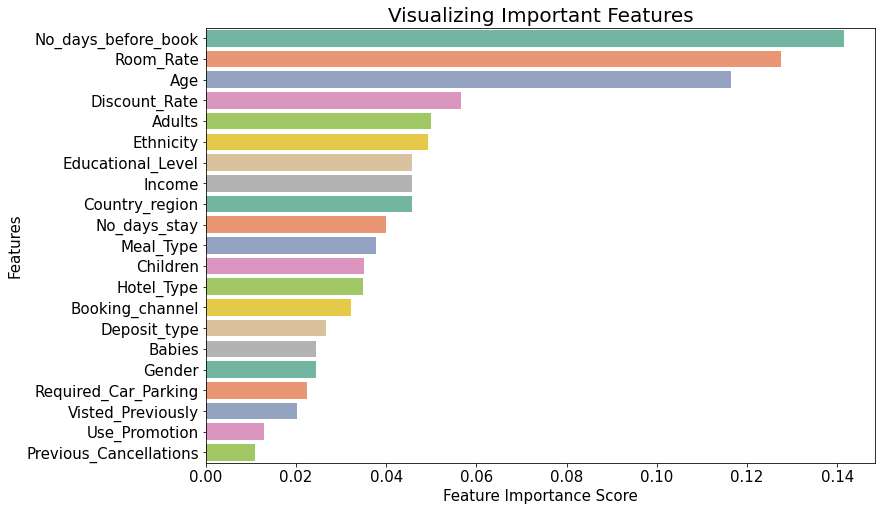

In [ ]:
plt.figure(figsize = (12,8))
sns.barplot(x = feature_imp, y = feature_imp.index, palette = 'Set2')
plt.xlabel('Feature Importance Score', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.title("Visualizing Important Features", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.savefig('RandomForest_featureImportance.png')
plt.show()

#### Hyper Parameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40],
    'max_features': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [100, 150, 200, 250]
}

In [ ]:
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 44.8min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 62.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 90.6min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 122.9min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 156.4min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 195.8min
[Parallel(n_jobs=-1)]: Done 5828 tasks      | elapsed: 241.5min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 252.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=0,
                                    

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    
    print('Model Performance')
    print('Confusion Matrix: {}'.format(confusion_matrix(y_val, y_pred)))
    print('Accuracy = {:0.2f}%.'.format(accuracy_score(y_val, y_pred)))
    print('F1 score = {:0.2f}%.'.format(f1_score(y_val, y_pred, average = 'micro')))
    

In [ ]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, x_val, y_val)

Model Performance
Confusion Matrix: [[   0  741    0]
 [   0 1610    0]
 [   0  398    0]]
Accuracy = 0.59%.
F1 score = 0.59%.
